# Install Package

In [ ]:
!pip install chemprop

# Prepare Dataset

In [1]:
from pathlib import Path

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd

from chemprop import data, featurizers, models, nn

In [2]:
input_path = "./dataset/chemprop/tests/data/regression/mol/mol.csv"
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'smiles' # name of the column containing SMILES strings
target_columns = ['lipo'] # list of names of the columns containing targets

df_input = pd.read_csv(input_path)

In [3]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values

all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]

mols = [d.mol for d in all_data]

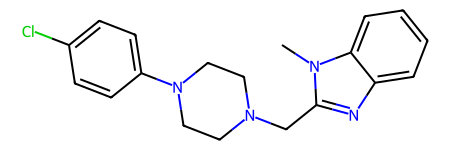

In [4]:
mols[0]

## Into pyg format

In [5]:
import numpy as np
import torch
from torch_geometric.data import Data
from rdkit import Chem

# Initialize the Chemprop featurizer
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

def smiles_to_graph_with_targets(smiles, targets, idx):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES

    # Use Chemprop featurizer to extract graph features
    try:
        mol_graph = featurizer(mol)  # MolGraph object
    except Exception as e:
        print(f"Error featurizing molecule {smiles}: {e}")
        return None

    # Extract atom and bond features
    atom_features = torch.tensor(mol_graph.V, dtype=torch.float)  # Node features
    bond_features = torch.tensor(mol_graph.E, dtype=torch.float)  # Edge features

    # Extract edge index
    edge_index = torch.tensor(mol_graph.edge_index, dtype=torch.long)

    # Reverse edge indices for bidirectional edges (optional, depends on model requirements)
    rev_edge_index = torch.tensor(mol_graph.rev_edge_index, dtype=torch.long)

    # Convert targets to numeric and handle invalid values
    targets = np.array(targets, dtype=np.float64)
    targets = torch.tensor(targets, dtype=torch.float).view(1, -1)

    # Create PyG Data object
    graph_data = Data(
        x=atom_features,
        edge_index=edge_index,
        edge_attr=bond_features,
        y=targets,
        smiles=smiles,
        idx=idx
    )
    return graph_data

# Function to filter simple molecules
def filter_simple_molecules(data):
    filtered_data = data.copy()
    for i, row in data.iterrows():
        smiles = row['smiles']
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            num_atoms = mol.GetNumAtoms()
            num_bonds = mol.GetNumBonds()
            # Exclude molecules with fewer than 3 atoms or 2 bonds
            if num_atoms < 3 or num_bonds < 2:
                filtered_data = filtered_data.drop(index=i)
        else:
            # Drop invalid SMILES
            filtered_data = filtered_data.drop(index=i)
    return filtered_data

# Preprocess the dataset to filter out simple molecules
df_filtered = filter_simple_molecules(df_input)

# Apply the function to the filtered dataset
graphs = []
for i, row in df_filtered.iterrows():
    try:
        # Extract regression targets and ensure they are numeric
        targets = row[['lipo']].values
        graph = smiles_to_graph_with_targets(row['smiles'], targets, i)
        if graph:
            graphs.append(graph)
    except Exception as e:
        print(f"Error processing row {i}: {e}")

In [6]:
graphs[0]

Data(x=[24, 72], edge_index=[2, 54], edge_attr=[54, 14], y=[1, 1], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', idx=0)

In [7]:
from torch_geometric.data import Data, InMemoryDataset

class CustomDataset(InMemoryDataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data, self.slices = self.collate(data_list)

In [8]:
chemprop_dataset = CustomDataset(graphs)

# Transformations

In [9]:
import torch
import copy
import networkx as nx
import random
import numpy as np
from torch_geometric.transforms import VirtualNode, AddLaplacianEigenvectorPE
from torch_geometric.utils import from_networkx, to_networkx, to_undirected, to_dense_adj, degree
from torch_geometric.data import InMemoryDataset
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomDataset(InMemoryDataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data, self.slices = self.collate(data_list)
        

###Visual Node
def apply_vn(pyg_dataset):
    vn_dataset = copy.deepcopy(pyg_dataset)  # Make a deep copy to preserve the original dataset
    transform = VirtualNode()

    # Create a list to store transformed graphs
    transformed_data_list = []

    for data in vn_dataset:
        transformed_data_list.append(transform(data))

    vn_dataset = CustomDataset(transformed_data_list)

    return vn_dataset

###Centrality
def add_centrality_to_node_features(data, centrality_measure='degree'):
    G = to_networkx(data, node_attrs=['x'], to_undirected=True)

    # Compute the centrality measure
    if centrality_measure == 'degree':
        centrality = nx.degree_centrality(G)
    elif centrality_measure == 'closeness':
        centrality = nx.closeness_centrality(G)
    elif centrality_measure == 'betweenness':
        centrality = nx.betweenness_centrality(G)
    elif centrality_measure == 'eigenvector':
        if not nx.is_connected(G):
        # Handle connected components separately
            centrality = {}
            for component in nx.connected_components(G):
                subgraph = G.subgraph(component)
                sub_centrality = nx.eigenvector_centrality(subgraph, max_iter=500, tol=1e-4)
                centrality.update(sub_centrality)
        else:
            centrality = nx.eigenvector_centrality(G, max_iter=500, tol=1e-4)
    else:
        raise ValueError(f'Unknown centrality measure: {centrality_measure}')
    
    # Convert centrality to tensor and add as node feature
    centrality_values = list(centrality.values())
    centrality_tensor = torch.tensor(centrality_values, dtype=torch.float).view(-1, 1)
    centrality_tensor = (centrality_tensor - centrality_tensor.mean()) / (centrality_tensor.std() + 1e-8)
    data.x = torch.cat([data.x, centrality_tensor], dim=-1)

    return data

def centrality(dataset, centrality_measure='degree'):
    original_dataset = copy.deepcopy(dataset)
    addCentrality_list = []
    for data in original_dataset:
        if centrality_measure == 'degree':
            data = add_centrality_to_node_features(data, centrality_measure='degree')
            addCentrality_list.append(data)
        elif centrality_measure == 'closeness':
            data = add_centrality_to_node_features(data, centrality_measure='closeness')
            addCentrality_list.append(data)
        elif centrality_measure == 'betweenness':
            data = add_centrality_to_node_features(data, centrality_measure='betweenness')
            addCentrality_list.append(data)
        elif centrality_measure == 'eigenvector':
            data = add_centrality_to_node_features(data, centrality_measure='eigenvector')
            addCentrality_list.append(data)
        else:
            raise ValueError(f'Unknown centrality measure: {centrality_measure}')
        
    addCentrality_dataset = CustomDataset(addCentrality_list)

    return addCentrality_dataset

###Distance Encoding
def distance_encoding_node_augmentation(data):
    G = to_networkx(data, node_attrs=['x'], to_undirected = True)
    num_nodes = data.num_nodes

    # Initialize the distance matrix with infinity
    distance_matrix = [[float('inf')] * num_nodes for _ in range(num_nodes)]
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    
    # Populate the distance matrix with actual shortest path lengths
    for i in range(num_nodes):
        distance_matrix[i][i] = 0  # Distance to self is 0
        if i in shortest_paths:
            for j, d in shortest_paths[i].items():
                distance_matrix[i][j] = d

    # Convert the distance matrix to a tensor
    distance_tensor = torch.tensor(distance_matrix, dtype=torch.float)
    
    # Example: Add average distance to node features
    finite_distances = torch.where(distance_tensor == float('inf'), torch.tensor(float('nan')), distance_tensor)
    average_distance = torch.nanmean(finite_distances, dim=1).view(-1, 1)  # Use nanmean to ignore infinities
    data.x = torch.cat([data.x, average_distance], dim=1)
    
    return data

def distance_encoding_edge_rewiring(data):
    """
    Add edges between all pairs of nodes with shortest path distance as a new edge attribute,
    while preserving original edge attributes.
    """
    G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'], to_undirected=True)
    G_transformed = G.copy()

    connected_components = list(nx.connected_components(G))
    shortest_paths = {}

    # Compute shortest paths for each connected component
    for component in connected_components:
        subgraph = G.subgraph(component)
        component_paths = dict(nx.all_pairs_shortest_path_length(subgraph))
        shortest_paths.update(component_paths)

    num_edge_attrs = data.edge_attr.shape[1] if data.edge_attr is not None else 0

    nodes = list(G.nodes)
    for i in nodes:
        for j in nodes:
            if i != j:
                if G.has_edge(i, j):
                    original_attr = G[i][j].get('edge_attr', [])
                    if not isinstance(original_attr, list):
                        original_attr = [original_attr]
                    G_transformed[i][j]['edge_attr'] = original_attr + [1]
                else:
                    if j in shortest_paths[i]:
                        distance = shortest_paths[i][j]
                    else:
                        distance = 1e9  # Replace inf with a large finite value
                    new_attr = [0] * num_edge_attrs + [distance]
                    G_transformed.add_edge(i, j, edge_attr=new_attr)

    new_data = from_networkx(G_transformed, group_node_attrs=['x'], group_edge_attrs=['edge_attr'])
    new_data.edge_attr = torch.tensor(new_data.edge_attr, dtype=torch.float)

    # Check for invalid values
    if torch.isnan(new_data.edge_attr).any() or torch.isinf(new_data.edge_attr).any():
        raise ValueError("Edge attributes contain invalid values!")

    new_data.y = data.y
    return new_data

def distance_encoding(dataset, method = 'node_augmentation'):
    original_dataset = copy.deepcopy(dataset)
    distance_encoding_list = []
    for data in original_dataset:
        if method == 'node_augmentation':
            data = distance_encoding_node_augmentation(data)
            distance_encoding_list.append(data)
        elif method == 'edge_rewiring':
            data = distance_encoding_edge_rewiring(data)
            distance_encoding_list.append(data)
        else:
            raise ValueError(f'Unknown distance encoding method: {method}')
    distance_encoding_dataset = CustomDataset(distance_encoding_list)
    return distance_encoding_dataset

###Subgraph Extraction
def extract_local_subgraph_features(data, radius=2):
    # Convert PyG data to NetworkX graph
    G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'], to_undirected=True)

    # Initialize a list to store subgraph features for each node
    subgraph_sizes = []
    subgraph_degrees = []
    
    for node in G.nodes():
        # Extract the ego graph (subgraph) around the node
        subgraph = nx.ego_graph(G, node, radius=radius)
        
        # Example feature 1: Size of the subgraph (number of nodes)
        subgraph_size = subgraph.number_of_nodes()
        subgraph_sizes.append(subgraph_size)
        
        # Example feature 2: Average degree of the subgraph
        subgraph_degree = np.mean([d for n, d in subgraph.degree()])
        subgraph_degrees.append(subgraph_degree)
        
    # Convert the features to tensors and add them as node features
    subgraph_sizes_tensor = torch.tensor(subgraph_sizes, dtype=torch.float).view(-1, 1)
    subgraph_degrees_tensor = torch.tensor(subgraph_degrees, dtype=torch.float).view(-1, 1)
    
    # Concatenate the new features to the existing node features
    data.x = torch.cat([data.x, subgraph_sizes_tensor, subgraph_degrees_tensor], dim=-1)
    
    return data

def subgraph_extraction(dataset, radius=2):
    original_dataset = copy.deepcopy(dataset)
    subgraph_extraction_list = []
    for data in original_dataset:
        data = extract_local_subgraph_features(data, radius=radius)
        subgraph_extraction_list.append(data)
    subgraph_extraction_dataset = CustomDataset(subgraph_extraction_list)
    return subgraph_extraction_dataset

def canonicalize_eigenvectors(eigenvectors):
    """
    Canonicalize eigenvectors by fixing their signs for consistency.
    This ensures that isomorphic graphs will have the same eigenvectors.
    """
    for i in range(eigenvectors.shape[1]):
        if eigenvectors[0, i] < 0:  # Flip sign if the first element is negative
            eigenvectors[:, i] = -eigenvectors[:, i]
    return eigenvectors

def add_canonicalized_laplacian_pe_pyg(data, k=5, max_features=12):
    """
    Add canonicalized Laplacian positional encoding to a PyG data object.

    Args:
        data (torch_geometric.data.Data): PyG data object.
        k (int): Number of Laplacian eigenvectors to compute.
        max_features (int): Total desired node feature dimensions after encoding.

    Returns:
        data (torch_geometric.data.Data): PyG data object with Laplacian PE appended to node features.
    """
    # Step 1: Convert PyG graph to NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Step 2: Compute sparse adjacency matrix
    adj = nx.to_scipy_sparse_array(G, format='csr').astype(np.float64)

    # Step 3: Compute normalized Laplacian matrix
    laplacian = csgraph.laplacian(adj, normed=True)

    # Step 4: Handle small graphs
    num_nodes = adj.shape[0]
    if num_nodes <= 1:
        raise ValueError(f"Graph has too few nodes ({num_nodes}) for Laplacian PE.")
    num_eigenvectors = min(k, num_nodes - 1)  # Ensure k < num_nodes

    # Step 5: Compute the smallest eigenvectors using sparse methods
    eigenvalues, eigenvectors = eigsh(laplacian, k=num_eigenvectors, which='SM')  # Smallest magnitude eigenvalues

    # Step 6: Canonicalize eigenvectors
    eigenvectors = canonicalize_eigenvectors(torch.tensor(eigenvectors, dtype=torch.float))

    # Step 7: Pad eigenvectors if less than max_features
    padding = torch.zeros((eigenvectors.shape[0], max_features - num_eigenvectors))
    eigenvectors = torch.cat([eigenvectors, padding], dim=1)

    # Step 8: Append the eigenvectors as new node features
    if 'x' in data:
        num_existing_features = data.x.shape[1]
        padding_existing = torch.zeros((data.x.shape[0], max_features - num_existing_features))
        data.x = torch.cat([data.x, padding_existing, eigenvectors], dim=1)
    else:
        data.x = eigenvectors

    return data

def graph_encoding(dataset, k=3, max_features=76, batch_size=100):
    """
    Apply canonicalized Laplacian positional encoding to a PyG dataset in batches.

    Args:
        dataset (list of torch_geometric.data.Data): List of PyG data objects.
        k (int): Number of Laplacian eigenvectors to compute.
        max_features (int): Total desired node feature dimensions after encoding.
        batch_size (int): Number of graphs to process in each batch.

    Returns:
        encoded_dataset (list of torch_geometric.data.Data): List of PyG data objects with Laplacian PE added.
    """
    encoded_dataset = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i + batch_size]
        for data in batch:
            data_copy = data.clone()  # Ensure original dataset remains unchanged
            try:
                graph_pe = add_canonicalized_laplacian_pe_pyg(data_copy, k=k, max_features=max_features)
                encoded_dataset.append(graph_pe)
            except Exception as e:
                print(f"Error processing graph (index {i}): {e}")
    ge_dataset = CustomDataset(encoded_dataset)
    return ge_dataset

###Add Extra Node on Each Edge
def add_extra_node_on_each_edge(data):
    # Convert PyG data to a NetworkX graph for easier manipulation
    G = to_networkx(data, node_attrs=['x'], edge_attrs = ['edge_attr'])
    
    # Original number of nodes
    num_original_nodes = G.number_of_nodes()
    
    # Prepare lists for new features
    edges = list(G.edges(data=True))
    new_node_features = []
    new_edges_src = []
    new_edges_dst = []
    new_edge_features = []

    for u, v, edge_data in edges:
        # Remove the original edge
        G.remove_edge(u, v)

        # Create new node as the mean of connected node features
        new_node_id = num_original_nodes + len(new_node_features)
        new_node_feature = (data.x[u] + data.x[v]) / 2
        new_node_features.append(new_node_feature)
        
        # Add new node with feature
        G.add_node(new_node_id, x=new_node_feature)

        # Add edges from new node to each original node
        G.add_edge(u, new_node_id)
        G.add_edge(new_node_id, v)

        # Use original edge feature for each new edge
        edge_feature = edge_data['edge_attr']
        edge_feature_tensor = (
            edge_feature if isinstance(edge_feature, torch.Tensor) else torch.tensor(edge_feature)
        )
        new_edge_features.append(edge_feature_tensor)  # for edge (u, new_node_id)
        new_edge_features.append(edge_feature_tensor)  # for edge (new_node_id, v)
    
    # Convert back to PyG Data object
    modified_data = from_networkx(G)

    # Update node features
    modified_data.x = torch.cat([data.x, torch.stack(new_node_features)], dim=0)

    # Update edge features to include only the new edges
    modified_data.edge_attr = torch.stack(new_edge_features)  # Only include new edge features

    # Preserve any additional global attributes
    modified_data.y = data.y
    
    return modified_data

def extra_node(dataset):
    original_dataset = copy.deepcopy(dataset)
    extra_node_list = []
    for data in original_dataset:
        data = add_extra_node_on_each_edge(data)
        extra_node_list.append(data)
    extra_node_dataset = CustomDataset(extra_node_list)
    return extra_node_dataset

def count_3_star(G):
    """Count 3-star graphlets for each node."""
    star_counts = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        degree = len(neighbors)
        # Count the number of 3-combinations of neighbors
        star_counts[node] = max(0, (degree * (degree - 1) * (degree - 2)) // 6)
    return star_counts

def count_tailed_triangle(G):
    """Count tailed triangle graphlets for each node."""
    tail_counts = {node: 0 for node in G.nodes()}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            for other in neighbors:
                if neighbor != other and G.has_edge(neighbor, other):
                    for extra in G.neighbors(node):
                        if extra not in {neighbor, other}:
                            tail_counts[node] += 1
    return tail_counts

def count_4_cycle(G):
    """Count 4-cycle graphlets for each node in an undirected graph G."""
    cycle_counts = {node: 0 for node in G.nodes()}
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        # Iterate over all unique neighbor pairs
        for i, neighbor1 in enumerate(neighbors):
            for neighbor2 in neighbors[i + 1:]:
                # Find common neighbors of neighbor1 and neighbor2
                shared_neighbors = set(G.neighbors(neighbor1)).intersection(G.neighbors(neighbor2))
                # Add the count of shared neighbors to node's 4-cycle count
                cycle_counts[node] += len(shared_neighbors)
    
    # Each 4-cycle is counted 4 times (once per node in the cycle)
    cycle_counts = {node: count // 4 for node, count in cycle_counts.items()}
    
    return cycle_counts

def graphlet_based_encoding_pyg(data):
    """
    Add graphlet-based features (3-star, triangle, tailed triangle, 4-cycle) to node features in PyG.

    Args:
        data: PyG Data object.

    Returns:
        data: PyG Data object with graphlet-based features added.
    """
    # Convert PyG graph to NetworkX
    G = to_networkx(data, to_undirected=True)

    # Count graphlets
    triangle_counts = nx.triangles(G)  # Triangle counts
    star_counts = count_3_star(G)  # 3-star graphlets
    tail_counts = count_tailed_triangle(G)  # Tailed triangles
    cycle_counts = count_4_cycle(G)  # 4-cycles

    # Combine features into tensors
    num_nodes = data.num_nodes
    triangle_tensor = torch.tensor([triangle_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)
    star_tensor = torch.tensor([star_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)
    tail_tensor = torch.tensor([tail_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)
    cycle_tensor = torch.tensor([cycle_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)

    # Concatenate all graphlet features
    graphlet_features = torch.cat([triangle_tensor, star_tensor, tail_tensor, cycle_tensor], dim=1)

    # Add to node features
    if data.x is not None:
        data.x = torch.cat([data.x, graphlet_features], dim=1)
    else:
        data.x = graphlet_features

    return data

def graphlet_encoding_dataset(dataset):
    """
    Apply graphlet-based encoding to a PyG dataset.

    Args:
        dataset: List of PyG Data objects.

    Returns:
        encoded_dataset: List of PyG Data objects with graphlet-based features added.
    """
    encoded_dataset = []
    for data in dataset:
        data_copy = data.clone()  # Use PyG's clone method for deep copy
        graph_encoded = graphlet_based_encoding_pyg(data_copy)
        encoded_dataset.append(graph_encoded)
    gle_dataset = CustomDataset(encoded_dataset)
    return gle_dataset

In [10]:
import copy
chemprop_original = copy.deepcopy(chemprop_dataset)
chemprop_vn = apply_vn(chemprop_dataset)
chemprop_deg = centrality(chemprop_dataset, centrality_measure='degree')
chemprop_clo = centrality(chemprop_dataset, centrality_measure='closeness')
chemprop_bet = centrality(chemprop_dataset, centrality_measure='betweenness')
chemprop_eig = centrality(chemprop_dataset, centrality_measure='eigenvector')
chemprop_de_n = distance_encoding(chemprop_dataset, method='node_augmentation')
chemprop_de_g = distance_encoding(chemprop_dataset, method='edge_rewiring')
chemprop_ge = graph_encoding(chemprop_dataset, k=3)
chemprop_se = subgraph_extraction(chemprop_dataset, radius=3)
chemprop_exN = extra_node(chemprop_dataset)
chemprop_gle = graphlet_encoding_dataset(chemprop_dataset)


/var/folders/ml/8lnl08s13tj5jbb_fkzftzfw0000gn/T/ipykernel_8008/50909257.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_data.edge_attr = torch.tensor(new_data.edge_attr, dtype=torch.float)


# GNN Models

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import PNAConv, global_add_pool
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d

class PNANet(torch.nn.Module):
    def __init__(self, num_node_features, dim_h, edge_attr, aggregators, scalers, deg):
        super(PNANet, self).__init__()
        self.input_proj = Linear(num_node_features, dim_h)  # Project input features to dim_h
        self.conv1 = PNAConv(
            in_channels=dim_h,
            out_channels=dim_h,
            aggregators=aggregators,
            scalers=scalers,
            deg=deg,
            edge_dim=edge_attr
        )
        self.bn1 = BatchNorm1d(dim_h)
        self.conv2 = PNAConv(
            in_channels=dim_h,
            out_channels=dim_h,
            aggregators=aggregators,
            scalers=scalers,
            deg=deg,
            edge_dim=edge_attr
        )
        self.bn2 = BatchNorm1d(dim_h)
        self.conv3 = PNAConv(
            in_channels=dim_h,
            out_channels=dim_h,
            aggregators=aggregators,
            scalers=scalers,
            deg=deg,
            edge_dim=edge_attr
        )
        self.bn3 = BatchNorm1d(dim_h)
        self.lin1 = Linear(dim_h * 3, dim_h * 3)
        self.lin2 = Linear(dim_h * 3, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = x.to(torch.float32)
        edge_attr = edge_attr.to(torch.float32)

        # Project input features
        x_proj = self.input_proj(x)

        h1 = F.relu(self.bn1(self.conv1(x_proj, edge_index, edge_attr)))
        h1 = F.dropout(h1, p=0.3, training=self.training)
        h2 = F.relu(self.bn2(self.conv2(h1 + x_proj, edge_index, edge_attr)))  # Residual connection
        h2 = F.dropout(h2, p=0.3, training=self.training)
        h3 = F.relu(self.bn3(self.conv3(h2 + h1, edge_index, edge_attr)))  # Residual connection
        h3 = F.dropout(h3, p=0.3, training=self.training)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)
        h = F.relu(self.lin1(h))
        h = F.dropout(h, p=0.5, training=self.training)
        return self.lin2(h)


import torch
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_add_pool
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d

class GINENet(torch.nn.Module):
    def __init__(self, num_node_features, dim_h, edge_attr):
        super(GINENet, self).__init__()
        
        # Define GINE layers with the specified edge_dim
        self.conv1 = GINEConv(
            Sequential(Linear(num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()),
            edge_dim=edge_attr)
        self.conv2 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()),
            edge_dim=edge_attr)
        self.conv3 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()),
            edge_dim=edge_attr)
        
        # Define linear layers for classification or regression
        self.lin1 = Linear(dim_h * 3, dim_h * 3)
        self.lin2 = Linear(dim_h * 3, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Pass node features and edge attributes through GINE layers
        h1 = self.conv1(x, edge_index, edge_attr)
        h2 = self.conv2(h1, edge_index, edge_attr)
        h3 = self.conv3(h2, edge_index, edge_attr)

        # Apply global pooling for graph-level output
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate pooled features and pass through final linear layers
        h = torch.cat((h1, h2, h3), dim=1)
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        return h

# Training, Validation, Testing

In [12]:
def training(loader, model, loss, optimizer):
    """Training for one epoch.

    Args:
        loader (DataLoader): Training data divided into batches.
        model (nn.Module): GNN model to train on.
        loss (nn.Module): Loss function to use during training.
        optimizer (torch.optim.Optimizer): Optimizer during training.

    Returns:
        tuple: Training loss (float), updated model.
    """
    model.train()
    total_loss = 0

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Ensure node features are in float format
        data.x = data.x.float()

        # Forward pass
        out = model(data)

        # Compute loss
        l = loss(out, data.y.view(-1, 1))
        total_loss += l.item()

        # Backward pass and optimization
        l.backward()
        optimizer.step()

    # Return average loss for the epoch
    avg_loss = total_loss / len(loader)
    return avg_loss, model


def validation(loader, model, loss):
    """Validation step.

    Args:
        loader (DataLoader): Validation set in batches.
        model (nn.Module): Current trained model.
        loss (nn.Module): Loss function.

    Returns:
        float: Validation loss.
    """
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            # Forward pass
            out = model(data)

            # Compute loss
            l = loss(out, data.y.view(-1, 1))
            total_loss += l.item()

    # Return average validation loss
    avg_loss = total_loss / len(loader)
    return avg_loss


@torch.no_grad()
def testing(loader, model):
    """Testing step.

    Args:
        loader (DataLoader): Test dataset in batches.
        model (nn.Module): Trained model.

    Returns:
        float: Test loss.
    """
    loss = torch.nn.MSELoss()
    total_loss = 0

    for data in loader:
        data = data.to(device)

        # Forward pass
        out = model(data)

        # Compute loss
        l = loss(out, data.y.view(-1, 1))
        total_loss += l.item()

    # Return average test loss
    avg_loss = total_loss / len(loader)
    return avg_loss

In [13]:
def train_epochs(epochs, model, train_loader, val_loader, model_path):
    """
    Train the model for a specified number of epochs.

    Args:
        epochs (int): Number of epochs to train.
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader, optional): DataLoader for validation data (can be None).
        model_path (str): Path to save the best model.

    Returns:
        best_val_loss (float): Lowest validation loss achieved.
        train_losses (list of float): Training losses over epochs.
        val_losses (list of float): Validation losses over epochs.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = torch.nn.L1Loss()  # Adjust criterion based on your task (e.g., regression or classification)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)  # Replace with appropriate criterion
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        
        train_losses.append(train_loss / len(train_loader.dataset))

        # Validation loop (if val_loader is provided)
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(device)
                    out = model(batch)
                    loss = criterion(out, batch.y)  # Replace with appropriate criterion
                    val_loss += loss.item() * batch.num_graphs

            val_losses.append(val_loss / len(val_loader.dataset))

            # Save model if it improves validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_path)
        else:
            # If no validation loader, save the model periodically
            if epoch % 10 == 0:
                torch.save(model.state_dict(), model_path)

        # Print progress
        # print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
        #       f"Val Loss: {val_losses[-1]:.4f}" if val_loader else f"Train Loss: {train_losses[-1]:.4f}")

    return best_val_loss, train_losses, val_losses if val_loader else train_losses

In [14]:
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))  # unpack the tuple into three separate lists

from sklearn.model_selection import KFold

k_splits = KFold(n_splits=5)
k_train_indices, k_val_indices, k_test_indices = [], [], []
for fold in k_splits.split(mols):
    k_train_indices.append(fold[0])
    k_val_indices.append([])
    k_test_indices.append(fold[1])



In [ ]:
import os
import numpy as np
import torch
from torch_geometric.data import DataLoader
from torch_geometric.utils import degree

# Assuming precomputed indices from Chemprop
# Example: These indices should be prepared using Chemprop's splitting logic
# train_indices, val_indices, test_indices for single splits
# k_train_indices, k_val_indices, k_test_indices for k-fold splits

results_folder = "./results/chemprop/lipo_cv/"
os.makedirs(results_folder, exist_ok=True)

# List of datasets with their respective names and transformations
datasets = [
    ('Base', chemprop_original),
    ('VN', chemprop_vn),
    ('DEG', chemprop_deg),
    ('BET', chemprop_bet),
    ('CLO', chemprop_clo),
    ('DE_N', chemprop_de_n),
    ('DE_G', chemprop_de_g),
    ('EXN', chemprop_exN),
    ('SE', chemprop_se),
    ('GE', chemprop_ge),
    ('EIG', chemprop_eig),
    ('GLE', chemprop_gle)
]

# Common parameters
epochs = 60
dim_h = 32
aggregators = ['mean', 'min', 'max', 'std']
scalers = ['identity', 'amplification', 'attenuation']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to compute mean and standard deviation of results
def compute_mean_std(results):
    results = np.array(results)
    mean = np.mean(results, axis=0)
    std = np.std(results, axis=0)
    return mean, std

# Loop through each dataset transformation
for name, dataset in datasets:
    print(f"\nProcessing dataset: {name}")

    # Normalize target
    data_mean = dataset.data.y.mean()
    data_std = dataset.data.y.std()
    dataset.data.y = (dataset.data.y - data_mean) / data_std

    # Use precomputed k-fold indices
    pna_fold_losses = []
    gin_fold_losses = []

    for fold in range(len(k_train_indices)):  # Iterate over k-fold splits
        print(f"\nFold {fold + 1}/{len(k_train_indices)}")

        # Get precomputed indices for this fold
        train_idx = k_train_indices[fold]
        val_idx = k_val_indices[fold] if k_val_indices else None
        test_idx = k_test_indices[fold]

        # Prepare PyG subsets
        train_data = [dataset[i] for i in train_idx]
        test_data = [dataset[i] for i in test_idx]

        train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

        # Determine maximum degree and degree histogram for training set
        max_degree = int(max([degree(data.edge_index[1], num_nodes=data.num_nodes).max().item() for data in train_data]))
        deg = torch.zeros(max_degree + 1, dtype=torch.long)
        for data in train_data:
            d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
            deg += torch.bincount(d, minlength=deg.numel())

        # Train and evaluate PNA model
        model = PNANet(dataset[0].x.shape[1], dim_h, edge_attr=dataset[0].edge_attr.shape[1],
                       aggregators=aggregators, scalers=scalers, deg=deg).to(device)
        model_path = f"{results_folder}/PNA_lipo_model_{name}_fold{fold + 1}.pt"
        pna_best_loss, _, _ = train_epochs(epochs, model, train_loader, None, model_path)

        model.load_state_dict(torch.load(model_path))
        pna_test_loss = testing(test_loader, model)
        pna_fold_losses.append(pna_test_loss)

        # Train and evaluate GIN model
        model = GINENet(dataset[0].x.shape[1], dim_h=dim_h, edge_attr=dataset[0].edge_attr.shape[1]).to(device)
        model_path = f"{results_folder}/GIN_lipo_model_{name}_fold{fold + 1}.pt"
        gin_best_loss, _, _ = train_epochs(epochs, model, train_loader, None, model_path)

        model.load_state_dict(torch.load(model_path))
        gin_test_loss = testing(test_loader, model)
        gin_fold_losses.append(gin_test_loss)

    # Compute mean and standard deviation for PNA and GIN across folds
    pna_mean_loss, pna_std_loss = compute_mean_std(pna_fold_losses)
    gin_mean_loss, gin_std_loss = compute_mean_std(gin_fold_losses)

    # Print summary for each dataset
    print(f"\nResults for dataset: {name}")
    print(f"  PNA Test Loss: {pna_mean_loss:.4f} ± {pna_std_loss:.4f}")
    print(f"  GIN Test Loss: {gin_mean_loss:.4f} ± {gin_std_loss:.4f}")

    # Save results to file
    with open(f"{results_folder}/{name}_results.txt", "w") as f:
        f.write(f"Dataset: {name}\n")
        f.write(f"PNA Test Loss: {pna_mean_loss:.4f} ± {pna_std_loss:.4f}\n")
        f.write(f"GIN Test Loss: {gin_mean_loss:.4f} ± {gin_std_loss:.4f}\n")